# Team Assignment - Intentionally Blank

The following libraries should be installed before proceeding further:
- pandas
- numpy

In [69]:
#Import all necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import haversine as hs
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import folium
from folium import plugins
from folium.plugins import HeatMap
from branca.element import Figure

In addition to the available datasets from the team assignment the original dataset is read for additional information about each ride. The additional information contains the geographical coordinates for the start position and the end position of each ride.

In [70]:
# Reading in weather and philadelphia_2017 data
df_weather = pd.read_csv("data/weather_hourly_philadelphia.csv")
df_philadelphia_2017 = pd.read_csv("data/philadelphia_2017.csv")

# Additionally read the philadelphia data from the official website
data_philadelphia_2017_Q1 = pd.read_csv("data/indego_Q1_2017.csv")
data_philadelphia_2017_Q2 = pd.read_csv("data/indego_Q2_2017.csv")
data_philadelphia_2017_Q3 = pd.read_csv("data/indego_Q3_2017.csv")
data_philadelphia_2017_Q4 = pd.read_csv("data/indego_Q4_2017.csv")

## Preparing and cleaning data

### Preparing and cleaning the philadelphia datasets

In [71]:
# Concatenate all quarters of philadelphia data and convert them to a dataframe
df_philadelphia_website = pd.concat([data_philadelphia_2017_Q1, data_philadelphia_2017_Q2, data_philadelphia_2017_Q3, data_philadelphia_2017_Q4], ignore_index=True)

In [72]:
# Dropping the columns duration, start_station_id, end_station_id, plan_duration, trip_route_category, passholder_type, start_station, end_station
df_philadelphia_website.drop(['duration', 'start_station_id', 'end_station_id', 'plan_duration', 'trip_route_category', 'passholder_type', 'start_station', 'end_station', 'trip_id'], axis=1, inplace=True)
df_philadelphia_website

#Changing the type of start_time, end_time (df_philadelphia_2017 and df_philadelphia_website) and date_time (df_weather) to datetime type from pandas
df_philadelphia_website.loc[:,'start_time'] = pd.to_datetime(df_philadelphia_website['start_time'])
df_philadelphia_website.loc[:,'end_time'] = pd.to_datetime(df_philadelphia_website['end_time'])

df_philadelphia_2017.loc[:,'start_time'] = pd.to_datetime(df_philadelphia_2017['start_time'])
df_philadelphia_2017.loc[:,"end_time"] = pd.to_datetime(df_philadelphia_2017["end_time"])

#Sort dataframes by their corresponding time column
df_philadelphia_website.sort_values(["start_time"], inplace = True)
df_philadelphia_2017.sort_values(["start_time"], inplace = True)


#Resetting the indexes
df_philadelphia_website.reset_index(drop = True, inplace = True)
df_philadelphia_2017.reset_index(drop = True, inplace = True)

C:\Users\Paulo\AppData\Local\Temp\ipykernel_10824\495290899.py:6: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_philadelphia_website.loc[:,'start_time'] = pd.to_datetime(df_philadelphia_website['start_time'])
C:\Users\Paulo\AppData\Local\Temp\ipykernel_10824\495290899.py:7: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_philadelphia_website.loc[:,'end_time'] = pd.to_datetime(df_philadelphia_website['end_time'])
C:\Users\Paulo\AppData\Local\Temp\ipykernel_10824\495290899.py:9: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will att

Before we further clean the dataset for philadelphia its important to mention that we first deleted the irrelevant stations because some duplicate rows happen to have the same start time, end time and bike ids but different start and end stations like the "Virtual Station". Therefore we deleted those stations first to avoid deleting useful records. In the following example you can see that deleting the duplicates first could lead to deleting useful records and keeping irrelevant records which are deleted either way later.

In [73]:
df_philadelphia_2017[df_philadelphia_2017.duplicated(subset=['start_time', 'end_time', 'bike_id'], keep=False)].head(6)

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name
255753,2017-06-05 15:26:00,2017-06-05 15:27:00,3152,3152,11907,Indego30,"40th & Baltimore, Trolley Portal","40th & Baltimore, Trolley Portal"
255755,2017-06-05 15:26:00,2017-06-05 15:27:00,3000,3000,11907,Indego30,Virtual Station,Virtual Station
256143,2017-06-05 17:26:00,2017-06-05 17:31:00,3152,3024,11907,Walk-up,"40th & Baltimore, Trolley Portal","43rd & Chester, Clark Park"
256148,2017-06-05 17:26:00,2017-06-05 17:31:00,3000,3024,11907,Walk-up,Virtual Station,"43rd & Chester, Clark Park"
258113,2017-06-06 16:02:00,2017-06-06 16:33:00,3004,3000,5314,Indego30,Municipal Services Building Plaza,Virtual Station
258115,2017-06-06 16:02:00,2017-06-06 16:33:00,3004,3161,5314,Indego30,Municipal Services Building Plaza,30th Street Station East


The "3083" station does not exist as a real station. Furthermore the "Virtual Station" is used by staff to check in or check out a bike remotely for an event or when the bike was not properly checked in or out. Therefore we check the number of rows where one of those stations occur and delete those rows afterwards.

For further information please check the official site about the data and the station table [here](https://www.rideindego.com/about/data/).

In [74]:
print(r'Number of rows in df_philadelphia_2017 with "Virtual Station" and "3083" in the start station or end station: ',
 df_philadelphia_2017[(df_philadelphia_2017["start_station_name"] == "Virtual Station") | (df_philadelphia_2017["end_station_name"] == "Virtual Station") |
  (df_philadelphia_2017["start_station_name"] == "3083") | (df_philadelphia_2017["end_station_name"] == "3083")
  ].shape[0])

Number of rows in df_philadelphia_2017 with "Virtual Station" and "3083" in the start station or end station:  6512


In [75]:
# Deleting "Virtual Station" and "3083" from the start_station_name and end_station_name columns
df_philadelphia_2017 = df_philadelphia_2017[(df_philadelphia_2017["start_station_name"] != "3083") & (df_philadelphia_2017["end_station_name"] != "3083") ]
df_philadelphia_2017 = df_philadelphia_2017[(df_philadelphia_2017["start_station_name"] != "Virtual Station") & (df_philadelphia_2017["end_station_name"] != "Virtual Station") ]

display(df_philadelphia_2017[(df_philadelphia_2017["start_station_name"] == "Virtual Station") | (df_philadelphia_2017["end_station_name"] == "Virtual Station") | (df_philadelphia_2017["start_station_name"] == "3083") | (df_philadelphia_2017["end_station_name"] == "3083")])

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name


The "bike_id" should be unique to one bike. No trip with the same bike_id should start and end on the same time interval. 

In [76]:
#Checking for any duplicates in philadelphia data
print("Number of duplicates in df_philadelphia_2017: ", df_philadelphia_2017.duplicated(subset=['start_time', 'end_time', 'bike_id']).sum())
print("Number of duplicates in df_philadelphia_website: ", df_philadelphia_website.duplicated(subset=['start_time', 'end_time', 'bike_id']).sum())

Number of duplicates in df_philadelphia_2017:  55
Number of duplicates in df_philadelphia_website:  68


In [77]:
#Dropping all duplicates for the philadelphia data depending on the start_time, end_time and bike_id
df_philadelphia_2017.drop_duplicates(subset=["start_time", "end_time", "bike_id"], keep="first", inplace=True)
df_philadelphia_website.drop_duplicates(subset=["start_time", "end_time", "bike_id"], keep="first", inplace=True)

display(df_philadelphia_2017[df_philadelphia_2017.duplicated(subset=['start_time', 'end_time', 'bike_id'])].head(10))
display(df_philadelphia_website[df_philadelphia_website.duplicated(subset=['start_time', 'end_time', 'bike_id'])].head(10))

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name


,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id


In [78]:
# Joining df_philadelphia_2017 with df_philadelphia_full on start_time, end_time, bike_id and dropping duplicate columns
df_philadelphia_2017_joined = df_philadelphia_2017.merge(df_philadelphia_website, on=["start_time", "end_time", "bike_id"], how="left")

df_philadelphia_2017_joined

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon
0,2017-01-01 00:05:00,2017-01-01 00:16:00,3046,3041,5347,Indego30,2nd & Market,"Girard Station, MFL",39.950119,-75.144722,39.968491,-75.135460
1,2017-01-01 00:21:00,2017-01-01 00:57:00,3110,3054,3364,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202
2,2017-01-01 00:22:00,2017-01-01 00:57:00,3110,3054,2536,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202
3,2017-01-01 00:27:00,2017-01-01 00:39:00,3041,3005,5176,Indego30,"Girard Station, MFL","Welcome Park, NPS",39.968491,-75.135460,39.947330,-75.144028
4,2017-01-01 00:28:00,2017-01-01 00:36:00,3047,3124,5370,Walk-up,"Independence Mall, NPS",Race Street Pier,39.950710,-75.149208,39.952950,-75.139793
...,...,...,...,...,...,...,...,...,...,...,...,...
782335,2017-12-31 23:05:00,2017-12-31 23:33:00,3070,3124,3708,Indego30,"Spring Garden Station, MFL",Race Street Pier,39.960621,-75.139832,39.952950,-75.139793
782336,2017-12-31 23:11:00,2018-01-01 11:03:00,3107,3165,5117,Indego30,33rd & Reservoir,24th & Race SRT,39.982029,-75.188660,39.958191,-75.178200
782337,2017-12-31 23:18:00,2017-12-31 23:25:00,3033,3046,11933,Indego30,10th & Chestnut,2nd & Market,39.950050,-75.156723,39.950119,-75.144722
782338,2017-12-31 23:39:00,2017-12-31 23:40:00,3163,3163,6725,Indego30,25th & Locust,25th & Locust,39.949741,-75.180969,39.949741,-75.180969


In [79]:
#Checking for missing values in philadelphia data
display(df_philadelphia_2017_joined[df_philadelphia_2017_joined.isnull().any(axis = 1)])

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon
255784,2017-06-06 16:02:00,2017-06-06 16:33:00,3004,3161,5314,Indego30,Municipal Services Building Plaza,30th Street Station East,39.953781,-75.163742,NaN,NaN
613438,2017-10-05 08:35:00,2017-10-05 08:47:00,3111,3107,5306,Indego30,"Parkside & Belmont, Case Building",33rd & Reservoir,NaN,NaN,39.982029,-75.18866
613848,2017-10-05 10:31:00,2017-10-05 10:53:00,3095,3111,5329,Indego30,29th & Diamond,"Parkside & Belmont, Case Building",39.987709,-75.180519,NaN,NaN


In [80]:
df_philadelphia_2017_joined.dropna(inplace = True)	

In [81]:
#Adding hour, month, weekday and trip duration(based on start and end time) to the table
df_philadelphia_2017_joined.loc[:,"trip_duration"] = df_philadelphia_2017_joined["end_time"] - df_philadelphia_2017_joined["start_time"] 
df_philadelphia_2017_joined.loc[:,"month"] = df_philadelphia_2017_joined["start_time"].dt.month
df_philadelphia_2017_joined.loc[:,"week"] = df_philadelphia_2017_joined["start_time"].dt.isocalendar().week
df_philadelphia_2017_joined.loc[:,"weekday"] = df_philadelphia_2017_joined["start_time"].dt.weekday
df_philadelphia_2017_joined.loc[:,"day"] = df_philadelphia_2017_joined["start_time"].dt.day
df_philadelphia_2017_joined.loc[:,"hour"] = df_philadelphia_2017_joined["start_time"].dt.hour
df_philadelphia_2017_joined

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon,trip_duration,month,week,weekday,day,hour
0,2017-01-01 00:05:00,2017-01-01 00:16:00,3046,3041,5347,Indego30,2nd & Market,"Girard Station, MFL",39.950119,-75.144722,39.968491,-75.135460,0 days 00:11:00,1,52,6,1,0
1,2017-01-01 00:21:00,2017-01-01 00:57:00,3110,3054,3364,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202,0 days 00:36:00,1,52,6,1,0
2,2017-01-01 00:22:00,2017-01-01 00:57:00,3110,3054,2536,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202,0 days 00:35:00,1,52,6,1,0
3,2017-01-01 00:27:00,2017-01-01 00:39:00,3041,3005,5176,Indego30,"Girard Station, MFL","Welcome Park, NPS",39.968491,-75.135460,39.947330,-75.144028,0 days 00:12:00,1,52,6,1,0
4,2017-01-01 00:28:00,2017-01-01 00:36:00,3047,3124,5370,Walk-up,"Independence Mall, NPS",Race Street Pier,39.950710,-75.149208,39.952950,-75.139793,0 days 00:08:00,1,52,6,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782335,2017-12-31 23:05:00,2017-12-31 23:33:00,3070,3124,3708,Indego30,"Spring Garden Station, MFL",Race Street Pier,39.960621,-75.139832,39.952950,-75.139793,0 days 00:28:00,12,52,6,31,23
782336,2017-12-31 23:11:00,2018-01-01 11:03:00,3107,3165,5117,Indego30,33rd & Reservoir,24th & Race SRT,39.982029,-75.188660,39.958191,-75.178200,0 days 11:52:00,12,52,6,31,23
782337,2017-12-31 23:18:00,2017-12-31 23:25:00,3033,3046,11933,Indego30,10th & Chestnut,2nd & Market,39.950050,-75.156723,39.950119,-75.144722,0 days 00:07:00,12,52,6,31,23
782338,2017-12-31 23:39:00,2017-12-31 23:40:00,3163,3163,6725,Indego30,25th & Locust,25th & Locust,39.949741,-75.180969,39.949741,-75.180969,0 days 00:01:00,12,52,6,31,23


We also remove trips which are shorter than one minute and longer than one day because the bike sharing service does not allow those trips normally.

In [82]:
df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] < "0 days 00:01:00"]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon,trip_duration,month,week,weekday,day,hour
699155,2017-11-05 01:35:00,2017-11-05 01:03:00,3118,3111,6694,Indego30,"46th Street Station, MFL","Parkside & Belmont, Case Building",39.958660,-75.213226,39.977791,-75.213226,-1 days +23:28:00,11,44,6,5,1
699158,2017-11-05 01:39:00,2017-11-05 01:35:00,3066,3066,2551,Indego30,19th & Lombard,19th & Lombard,39.945610,-75.173477,39.945610,-75.173477,-1 days +23:56:00,11,44,6,5,1
699163,2017-11-05 01:51:00,2017-11-05 01:20:00,3157,3041,11750,Indego30,"8th & Mifflin, Bok Building","Girard Station, MFL",39.925449,-75.159538,39.968491,-75.135460,-1 days +23:29:00,11,44,6,5,1


In [83]:
df_philadelphia_2017_joined = df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] >= "0 days 00:01:00"]
df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] < "0 days 00:01:00"]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon,trip_duration,month,week,weekday,day,hour


In [84]:
df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] > "1 days"]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon,trip_duration,month,week,weekday,day,hour
682,2017-01-01 18:19:00,2017-01-03 08:04:00,3072,3125,5354,Walk-up,Front & Carpenter,15th & South,39.934448,-75.145409,39.943909,-75.167351,1 days 13:45:00,1,52,6,1,18
20987,2017-01-23 15:19:00,2017-01-24 16:14:00,3038,3028,2492,Indego30,The Children's Hospital of Philadelphia (CHOP),4th & Bainbridge,39.947811,-75.194092,39.940609,-75.149582,1 days 00:55:00,1,4,0,23,15
24873,2017-01-26 17:31:00,2017-01-28 10:00:00,3021,3109,5185,Indego30,18th & JFK,Parkside & Girard,39.953899,-75.169022,39.974861,-75.205238,1 days 16:29:00,1,4,3,26,17
27216,2017-01-28 15:46:00,2017-01-30 08:01:00,3012,3034,5255,Walk-up,21st & Catharine,11th & Reed,39.942181,-75.177467,39.933151,-75.162483,1 days 16:15:00,1,4,5,28,15
32762,2017-02-02 09:45:00,2017-02-03 17:59:00,3054,3021,5125,Indego30,Rodin Museum,18th & JFK,39.962502,-75.174202,39.953899,-75.169022,1 days 08:14:00,2,5,3,2,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735895,2017-11-25 12:12:00,2017-11-27 07:31:00,3112,3020,11894,Indego30,48th & Spruce,University City Station,39.953732,-75.218246,39.949219,-75.190361,1 days 19:19:00,11,47,5,25,12
749711,2017-12-02 13:00:00,2017-12-03 14:12:00,3040,3073,11928,Walk-up,17th & Spring Garden,9th & Spring Garden,39.962891,-75.166061,39.961430,-75.152420,1 days 01:12:00,12,48,5,2,13
763091,2017-12-11 11:46:00,2017-12-12 13:15:00,3018,3037,3367,Indego30,12th & Filbert,Pennsylvania Convention Center,39.952728,-75.159790,39.954239,-75.161377,1 days 01:29:00,12,50,0,11,11
768955,2017-12-15 19:27:00,2017-12-17 16:32:00,3026,3072,11932,Indego30,2nd & South,Front & Carpenter,39.941380,-75.145638,39.934448,-75.145409,1 days 21:05:00,12,50,4,15,19


In [85]:
df_philadelphia_2017_joined = df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] <= "1 days"]
df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] > "1 days"]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon,trip_duration,month,week,weekday,day,hour


In [86]:
df_philadelphia_cleaned = df_philadelphia_2017_joined.copy()
df_philadelphia_cleaned

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon,trip_duration,month,week,weekday,day,hour
0,2017-01-01 00:05:00,2017-01-01 00:16:00,3046,3041,5347,Indego30,2nd & Market,"Girard Station, MFL",39.950119,-75.144722,39.968491,-75.135460,0 days 00:11:00,1,52,6,1,0
1,2017-01-01 00:21:00,2017-01-01 00:57:00,3110,3054,3364,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202,0 days 00:36:00,1,52,6,1,0
2,2017-01-01 00:22:00,2017-01-01 00:57:00,3110,3054,2536,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202,0 days 00:35:00,1,52,6,1,0
3,2017-01-01 00:27:00,2017-01-01 00:39:00,3041,3005,5176,Indego30,"Girard Station, MFL","Welcome Park, NPS",39.968491,-75.135460,39.947330,-75.144028,0 days 00:12:00,1,52,6,1,0
4,2017-01-01 00:28:00,2017-01-01 00:36:00,3047,3124,5370,Walk-up,"Independence Mall, NPS",Race Street Pier,39.950710,-75.149208,39.952950,-75.139793,0 days 00:08:00,1,52,6,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782335,2017-12-31 23:05:00,2017-12-31 23:33:00,3070,3124,3708,Indego30,"Spring Garden Station, MFL",Race Street Pier,39.960621,-75.139832,39.952950,-75.139793,0 days 00:28:00,12,52,6,31,23
782336,2017-12-31 23:11:00,2018-01-01 11:03:00,3107,3165,5117,Indego30,33rd & Reservoir,24th & Race SRT,39.982029,-75.188660,39.958191,-75.178200,0 days 11:52:00,12,52,6,31,23
782337,2017-12-31 23:18:00,2017-12-31 23:25:00,3033,3046,11933,Indego30,10th & Chestnut,2nd & Market,39.950050,-75.156723,39.950119,-75.144722,0 days 00:07:00,12,52,6,31,23
782338,2017-12-31 23:39:00,2017-12-31 23:40:00,3163,3163,6725,Indego30,25th & Locust,25th & Locust,39.949741,-75.180969,39.949741,-75.180969,0 days 00:01:00,12,52,6,31,23


### Preparing and cleaning the weather dataset

After preparing and cleaning the philadelphia dataset we need to do most of the procedure on the weather dataset.

In [87]:
#Changing the type of date_time (df_weather) to datetime type from pandas
df_weather.loc[:, "date_time"] = pd.to_datetime(df_weather["date_time"])

#Sort the dataframe by their corresponding time column
df_weather.sort_values(["date_time"], inplace = True)

#Reset the index
df_weather.reset_index(drop = True, inplace =True)

C:\Users\Paulo\AppData\Local\Temp\ipykernel_10824\1772864593.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_weather.loc[:, "date_time"] = pd.to_datetime(df_weather["date_time"])


First of all we check for duplicate rows in the weather data and delete them if they occur because we do not need multiple rows multiple times.

In [88]:
#Checking for any duplicates in weather data
print("Number of duplicates in df_weather: ", df_weather.duplicated().sum())

Number of duplicates in df_weather:  630


In [89]:
#Dropping all duplicates for the weather data
df_weather.drop_duplicates(subset= ["date_time"],inplace = True)

display(df_weather[df_weather.duplicated()])

,date_time,max_temp,min_temp,precip


We also check for null values in the weather data and delete them. It is important to note that we later add additional rows with null values but with the missing time intervals because we can interpolate them with the interpolate function in pandas.

In [90]:
#Checking for missing values in weather data
display(df_weather[df_weather.isnull().any(axis = 1)])

,date_time,max_temp,min_temp,precip
43785,NaT,NaN,NaN,NaN


In [91]:
df_weather.dropna(inplace = True)

Since the weather data consists of data from the beginning of 2015 until the end of 2019, we want to have as well only the weather data for 2017.

In [92]:
#Selecting data from the beginning of 2017 till the end of 2017
df_weather_2017 = df_weather[(df_weather["date_time"]>= "2017-01-01 00:00:00") & (df_weather["date_time"]< "2018-01-01 00:00:00" )]

In [93]:
#Add missing intervals in the weather data
df_weather_2017.set_index("date_time", inplace = True)
df_weather_2017 = df_weather_2017.resample("H").asfreq()

The minimum temperature and maximum temperature will be interpolated linearly. The precipitation value is interpolated by taking one of the nearest existing values.

In [94]:
# Interpolate missing values in the weather data
df_weather_2017["min_temp"].interpolate(method = "linear", inplace = True)
df_weather_2017["max_temp"].interpolate(method = "linear", inplace = True)
df_weather_2017["precip"].interpolate(method = "pad", inplace = True)
df_weather_2017.reset_index(drop=False, inplace = True)

# Check if null values in the weather data still exist
display(df_weather_2017[df_weather_2017.isnull().any(axis = 1)])
display(df_weather_2017)

,date_time,max_temp,min_temp,precip


,date_time,max_temp,min_temp,precip
0,2017-01-01 00:00:00,6.1,6.1,0.0
1,2017-01-01 01:00:00,6.1,6.1,0.0
2,2017-01-01 02:00:00,6.7,6.7,0.0
3,2017-01-01 03:00:00,7.2,7.2,0.0
4,2017-01-01 04:00:00,7.8,7.8,0.0
...,...,...,...,...
8755,2017-12-31 19:00:00,-8.9,-8.9,0.0
8756,2017-12-31 20:00:00,-8.9,-8.9,0.0
8757,2017-12-31 21:00:00,-9.4,-9.4,0.0
8758,2017-12-31 22:00:00,-10.0,-10.0,0.0


All dataframes for reference:
* **Philadelphia data**
   * *df_philadelphia_cleaned*
* **Weather data**
   * *df_weather_2017*

## Clustering

Ändern! <br>
In the following, we will perform unsupervised clustering. For this we use the K-Means Algorithm as we do not use any categorical features for clustering and for its' ease of use. Although Hierachical Clustering might be useful to achieve some first insights e.g. the amount of clusters for KMeans, we will not use it for this due to the large amount of samples. PCA is also not necessary as we are only focussing on a few features with expected high relevancy.

### General Data Prep

Before we can start with the clustering, we thought about a new feature for our clustering process. <br>
This feature will be the distance between start and end stations of every trip, which can be calculated <br>
with the Haversine library.

In [95]:
df_phil_clustering = df_philadelphia_cleaned.copy()

# Only done because its not done in the original data cleaning part, remove once happened
df_phil_clustering.reset_index(inplace=True, drop=True)

# Changing trip_duration from datetime type to an int -> probably should also be done in the original data cleaning part!
df_phil_clustering.loc[:, 'trip_duration'] = df_phil_clustering['trip_duration'].dt.seconds / 60
df_phil_clustering.rename(columns={'trip_duration': 'trip_duration in minutes'}, inplace=True)
df_phil_clustering['trip_duration in minutes'] = df_phil_clustering['trip_duration in minutes'].astype(int)

# Calculating the distance between start and end coordinates of stations as one of our features for Clustering
for i in range(0, len(df_phil_clustering)):
    combined_start_coordinates = (df_phil_clustering.at[i, 'start_lat'], df_phil_clustering.at[i, 'start_lon'])
    combined_end_coordinates = (df_phil_clustering.at[i, 'end_lat'], df_phil_clustering.at[i, 'end_lon'])

    # By default haversine uses km, so no need to set extra units
    df_phil_clustering.at[i, 'distance_in_km'] = hs.haversine(combined_start_coordinates, combined_end_coordinates)

In [96]:
# Finished dataframe
df_phil_clustering

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon,trip_duration in minutes,month,week,weekday,day,hour,distance_in_km
0,2017-01-01 00:05:00,2017-01-01 00:16:00,3046,3041,5347,Indego30,2nd & Market,"Girard Station, MFL",39.950119,-75.144722,39.968491,-75.135460,11,1,52,6,1,0,2.190094
1,2017-01-01 00:21:00,2017-01-01 00:57:00,3110,3054,3364,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202,36,1,52,6,1,0,3.221666
2,2017-01-01 00:22:00,2017-01-01 00:57:00,3110,3054,2536,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202,35,1,52,6,1,0,3.221666
3,2017-01-01 00:27:00,2017-01-01 00:39:00,3041,3005,5176,Indego30,"Girard Station, MFL","Welcome Park, NPS",39.968491,-75.135460,39.947330,-75.144028,12,1,52,6,1,0,2.463718
4,2017-01-01 00:28:00,2017-01-01 00:36:00,3047,3124,5370,Walk-up,"Independence Mall, NPS",Race Street Pier,39.950710,-75.149208,39.952950,-75.139793,8,1,52,6,1,0,0.840302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782220,2017-12-31 23:05:00,2017-12-31 23:33:00,3070,3124,3708,Indego30,"Spring Garden Station, MFL",Race Street Pier,39.960621,-75.139832,39.952950,-75.139793,28,12,52,6,31,23,0.852984
782221,2017-12-31 23:11:00,2018-01-01 11:03:00,3107,3165,5117,Indego30,33rd & Reservoir,24th & Race SRT,39.982029,-75.188660,39.958191,-75.178200,712,12,52,6,31,23,2.796533
782222,2017-12-31 23:18:00,2017-12-31 23:25:00,3033,3046,11933,Indego30,10th & Chestnut,2nd & Market,39.950050,-75.156723,39.950119,-75.144722,7,12,52,6,31,23,1.023025
782223,2017-12-31 23:39:00,2017-12-31 23:40:00,3163,3163,6725,Indego30,25th & Locust,25th & Locust,39.949741,-75.180969,39.949741,-75.180969,1,12,52,6,31,23,0.000000


### Functions to use for Clustering

In [97]:
# This function is used to standardize features
def scalingData(dataframe):
    newDataframe = dataframe.copy()
    scaler = StandardScaler()
    newDataframe[newDataframe.columns] = pd.DataFrame(scaler.fit_transform(newDataframe[newDataframe.columns]))
    return newDataframe

In [98]:
# This function calculates the Loss per cluster amount and plots the result of it in the range of 0-10 on the x-axis
def calcAndPlotLoss(clusterAmount, dataframe):
    k_max = clusterAmount

    clusters = []
    losses = []

    for k in range(k_max):
        model = KMeans(n_clusters=k+1, n_init=10)
        model.fit(dataframe)
        clusters.append(k+1)
        losses.append(model.inertia_)

    fig = plt.subplots(figsize=(12,7))
    plt.plot(clusters, losses)
    plt.ylabel("Loss")
    plt.xlabel("Number of clusters")
    plt.xlim([0,10])
    plt.grid(True)
    plt.show()

In [99]:
# This function calculates for a the defined amount of clusters KMeans on the given dataframe
def calcKMeans(numClusters, dataframe):
    result = KMeans(n_clusters=numClusters, n_init=10)
    result.fit(dataframe)

    dataframe['Cluster'] = result.predict(dataframe)

In [100]:
# This function describes every KMeans cluster with the describe() function for the original dataframe
def describeData(originalDataframe, scaledDataframe, numClusters):   
    for i in range(0, numClusters):
        display(originalDataframe[scaledDataframe['Cluster'] == i].describe())

### Clustering Trip/Customer Types

For this we will use:
 - Total number of rides
 - Average Trip Duration in minutes
 - Average Trip Distance in km

In [101]:
#Count number of ride per weekday and hour
df_phil_clus_customer_types_wd_hr = df_phil_clustering.groupby(['weekday','hour'])['hour'].count().reset_index(name='n_rides')

#Aggregate trip duration and distance by weekday and hour
df_phil_clus_customer_types_agg = df_phil_clustering.groupby(['weekday','hour']).agg({'trip_duration in minutes': 'sum', 'distance_in_km': 'sum'}).reset_index()

#Merge both new dataframes
df_phil_clus_customer_types_merged = pd.merge(df_phil_clus_customer_types_agg, df_phil_clus_customer_types_wd_hr)

#Calculate average trip duration and distance
df_phil_clus_customer_types_merged['avg_trip_duration'] = df_phil_clus_customer_types_merged['trip_duration in minutes']/df_phil_clus_customer_types_merged['n_rides']
df_phil_clus_customer_types_merged['avg_trip_distance'] = df_phil_clus_customer_types_merged['distance_in_km']/df_phil_clus_customer_types_merged['n_rides']

df_phil_clus_customer_types_merged

,weekday,hour,trip_duration in minutes,distance_in_km,n_rides,avg_trip_duration,avg_trip_distance
0,0,0,25440,1394.803697,845,30.106509,1.650655
1,0,1,14259,678.613088,416,34.276442,1.631281
2,0,2,11219,411.024992,273,41.095238,1.505586
3,0,3,3817,223.898330,158,24.158228,1.417078
4,0,4,5122,467.304804,246,20.821138,1.899613
...,...,...,...,...,...,...,...
163,6,19,115243,7600.622249,5003,23.034779,1.519213
164,6,20,87366,5622.960210,3676,23.766594,1.529641
165,6,21,62810,4168.057497,2719,23.100405,1.532938
166,6,22,53831,3462.057835,2144,25.107743,1.614766


In [102]:
#Create DF to be used for clustering
df_phil_clus_customer_types_cluster = df_phil_clus_customer_types_merged[['n_rides','avg_trip_duration','avg_trip_distance']]
df_phil_clus_customer_types_cluster

,n_rides,avg_trip_duration,avg_trip_distance
0,845,30.106509,1.650655
1,416,34.276442,1.631281
2,273,41.095238,1.505586
3,158,24.158228,1.417078
4,246,20.821138,1.899613
...,...,...,...
163,5003,23.034779,1.519213
164,3676,23.766594,1.529641
165,2719,23.100405,1.532938
166,2144,25.107743,1.614766


In [103]:
#Scaling the Data
df_phil_clus_customer_types_cluster_scaled = scalingData(df_phil_clus_customer_types_cluster)
df_phil_clus_customer_types_cluster_scaled

,n_rides,avg_trip_duration,avg_trip_distance
0,-1.063363,1.339552,0.033204
1,-1.183062,1.981452,-0.171021
2,-1.222961,3.031106,-1.496007
3,-1.255048,0.423901,-2.428992
4,-1.230495,-0.089795,2.657529
...,...,...,...
163,0.096791,0.250963,-1.352363
164,-0.273465,0.363615,-1.242438
165,-0.540485,0.261065,-1.207687
166,-0.700920,0.570065,-0.345116


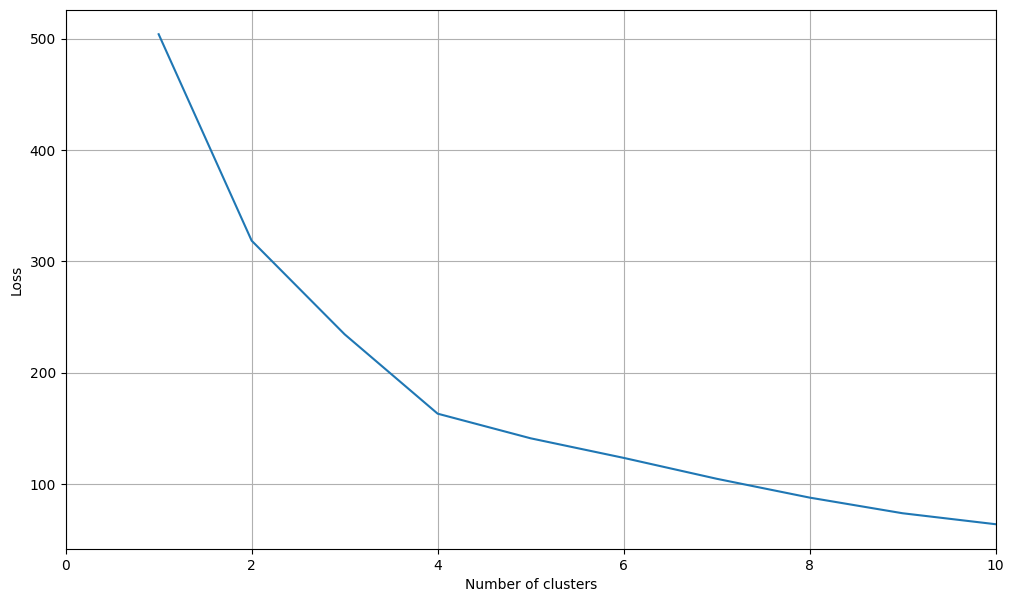

In [104]:
#Calculating the Loss with increasing number of Clusters
calcAndPlotLoss(10, df_phil_clus_customer_types_cluster_scaled)

Looking at the loss function, the amount of clusters should be between 2-4. By testing the cluster amount, 
<br> having 4 clusters finds similiar groups for customer/trip types. By using less clusters, the information gained<br>
from the clusters is difficult to interpret.

In [105]:
# Define the cluster amount here
cluster = 4

# Calculating KMeans
calcKMeans(cluster, df_phil_clus_customer_types_cluster_scaled)

# Adding the clusters from KMeans into the original dataframe 
df_phil_clus_customer_types_merged.loc[:, 'Cluster'] = df_phil_clus_customer_types_cluster_scaled['Cluster']

df_phil_clus_customer_types_merged

,weekday,hour,trip_duration in minutes,distance_in_km,n_rides,avg_trip_duration,avg_trip_distance,Cluster
0,0,0,25440,1394.803697,845,30.106509,1.650655,1
1,0,1,14259,678.613088,416,34.276442,1.631281,1
2,0,2,11219,411.024992,273,41.095238,1.505586,1
3,0,3,3817,223.898330,158,24.158228,1.417078,1
4,0,4,5122,467.304804,246,20.821138,1.899613,2
...,...,...,...,...,...,...,...,...
163,6,19,115243,7600.622249,5003,23.034779,1.519213,0
164,6,20,87366,5622.960210,3676,23.766594,1.529641,0
165,6,21,62810,4168.057497,2719,23.100405,1.532938,0
166,6,22,53831,3462.057835,2144,25.107743,1.614766,0


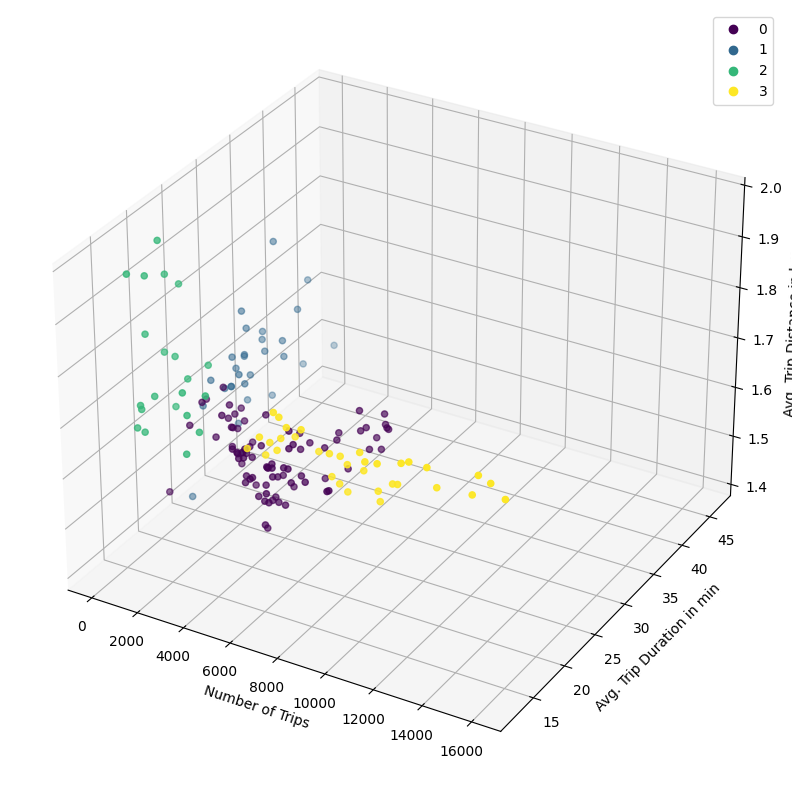

In [106]:
#Plotting the Clustering in 3D
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(xs=df_phil_clus_customer_types_merged['n_rides'], ys=df_phil_clus_customer_types_merged['avg_trip_duration'], zs=df_phil_clus_customer_types_merged['avg_trip_distance'], c=df_phil_clus_customer_types_merged['Cluster'])
plt.legend(*scatter.legend_elements())
plt.xlabel('Number of Trips')
plt.ylabel('Avg. Trip Duration in min')
ax.set_zlabel('Avg. Trip Distance in km')
plt.show()

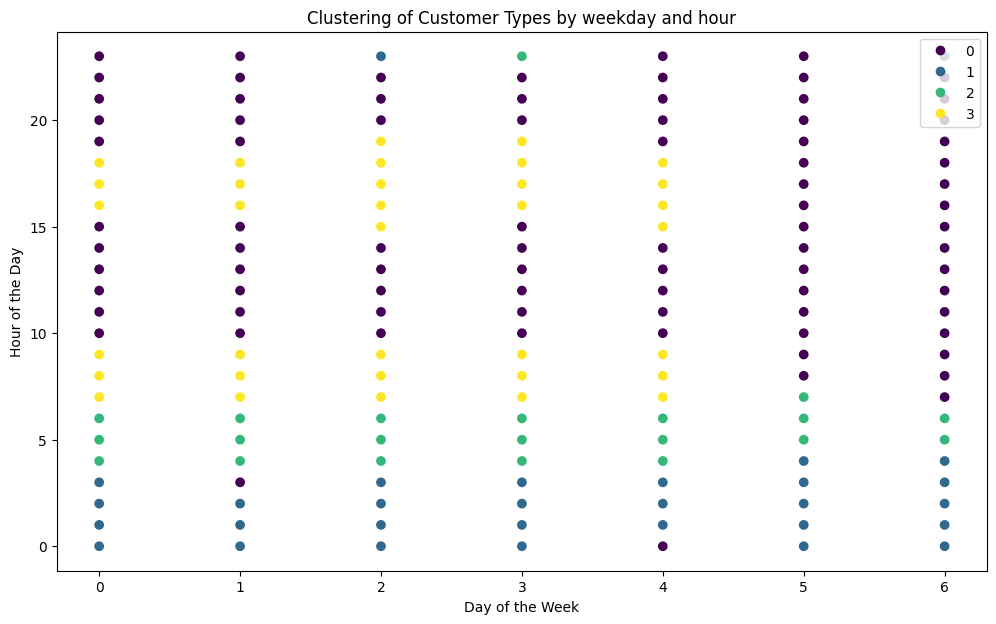

In [107]:
#Plot the cluster result by hour and weekday
df_phil_clus_customer_types_merged.columns = df_phil_clus_customer_types_merged.columns.astype(str)
plt.figure(figsize=(12,7))
scatter = plt.scatter(x=df_phil_clus_customer_types_merged['weekday'], y=df_phil_clus_customer_types_merged['hour'], c=df_phil_clus_customer_types_merged['Cluster'])
plt.legend(*scatter.legend_elements())
plt.title('Clustering of Customer Types by weekday and hour')
plt.xlabel('Day of the Week')
plt.ylabel('Hour of the Day')
plt.show()

In [108]:
describeData(df_phil_clus_customer_types_cluster, df_phil_clus_customer_types_cluster_scaled, 4)

,n_rides,avg_trip_duration,avg_trip_distance
count,83.000000,83.000000,83.000000
mean,4790.481928,21.366410,1.598112
std,1791.283185,3.092041,0.047153
min,112.000000,16.560976,1.462583
25%,3623.500000,18.881919,1.569715
50%,4799.000000,20.518935,1.608684
75%,5997.500000,23.661720,1.626701
max,8110.000000,27.991817,1.690540


,n_rides,avg_trip_duration,avg_trip_distance
count,30.000000,30.000000,30.000000
mean,664.600000,31.999291,1.601133
std,493.348908,5.267552,0.089904
min,142.000000,24.158228,1.417078
25%,261.750000,27.934570,1.540733
50%,440.500000,31.242673,1.626812
75%,894.000000,34.160617,1.649875
max,1720.000000,46.320930,1.800770


,n_rides,avg_trip_duration,avg_trip_distance
count,21.000000,21.000000,21.000000
mean,1526.714286,16.683422,1.780481
std,1289.202239,3.256720,0.091259
min,228.000000,12.349515,1.668644
25%,349.000000,13.764327,1.722561
50%,1212.000000,15.613821,1.750306
75%,1960.000000,19.683770,1.820270
max,4001.000000,22.775510,1.974023


,n_rides,avg_trip_duration,avg_trip_distance
count,34.000000,34.000000,34.000000
mean,9782.823529,15.064926,1.726869
std,2891.038562,1.622509,0.048032
min,5509.000000,12.642819,1.628455
25%,7439.500000,13.479119,1.694059
50%,9056.500000,14.982776,1.719940
75%,11407.500000,16.215522,1.765644
max,16009.000000,18.318668,1.807625


Based on the clustering results we can identify four different customers types. Cluster 0 represents Trips during the Rush hour as it only appears on weekdays aroung 8 AM and 5 PM. In terms of customer groups this is likely people renting a bycicle to get to and away from work (Rush-Hour Commuter). Clusters 1 represents customers (Night Riders) which ride during the night around 0 AM to 4 AM. Cluster 2 represents people riding bikes early in the morning (around 5 AM). Their behavior shows consistency across all weekdays with a small offset on the weekend (Early Birds). Cluster 3 represents the trips likely unrelated to work as they are especially prevelant on the weekends as well as after rush hours on weekdays (Spontaneous/Leisure Bikers).

### Clustering locations based demand patterns

For this we will use:
- Total trips of every start and end station
- Avg. trip Duration of every start and end station
- Avg. distance in kilometers between every start and end station

#### Start Stations

In [109]:
# Aggregation function to combine stations that have multiple stations in itself
agg_functions = {'start_station_name': 'first', 'start_lat': 'mean', 'start_lon': 'mean', 'total_started_trips': 'sum', 'trip_duration in minutes': 'sum', 'distance_in_km': 'sum'}

# Dataframe for the sum of trip duration and distance per station
descriptiveTripFeatures = df_phil_clustering.groupby(['start_station_name', 'start_lat', 'start_lon']).aggregate({'trip_duration in minutes': 'sum', 'distance_in_km': 'sum'}).reset_index()

# Dataframe for the amount of total trips per station
totalTripCount = df_phil_clustering.groupby(['start_station_name', 'start_lat', 'start_lon'])['start_station_name'].count().reset_index(name='total_started_trips')

# Merging both dataframes into one
df_phil_start_stations = pd.merge(totalTripCount, descriptiveTripFeatures, on=['start_station_name', 'start_lat', 'start_lon'])

# Show duplicates before aggregating them and one example
display(df_phil_start_stations[df_phil_start_stations.duplicated(subset=['start_station_name'], keep=False)])
display(df_phil_start_stations[df_phil_start_stations['start_station_name'] == '40th Street Station, MFL'])

# Aggregation
df_phil_start_stations = df_phil_start_stations.groupby(df_phil_start_stations['start_station_name']).aggregate(agg_functions).reset_index(drop=True)

# Show duplicates after aggregating to see if they are gone
display(df_phil_start_stations[df_phil_start_stations.duplicated(subset=['start_station_name'], keep=False)])
display(df_phil_start_stations[df_phil_start_stations['start_station_name'] == '40th Street Station, MFL'])

# Copying the original dataframe for visualization and dropping every unnecessary column for KMeans
df_phil_start_stations_original = df_phil_start_stations.copy()
df_phil_start_stations.drop(['start_station_name', 'start_lat', 'start_lon'], axis=1, inplace=True)

# Calculating avg values for both trip duration and the distance
df_phil_start_stations['avg_trip_duration in minutes'] = df_phil_start_stations['trip_duration in minutes'] / df_phil_start_stations['total_started_trips']
df_phil_start_stations['avg_distance_in_km'] = df_phil_start_stations['distance_in_km'] / df_phil_start_stations['total_started_trips']

df_phil_start_stations.drop(['trip_duration in minutes', 'distance_in_km'], axis=1, inplace=True)

df_phil_start_stations

,start_station_name,start_lat,start_lon,total_started_trips,trip_duration in minutes,distance_in_km
64,"40th Street Station, MFL",39.956940,-75.200691,2364,45014,4477.262612
65,"40th Street Station, MFL",39.957081,-75.201767,2184,35858,4310.390978
106,"Parkside & Belmont, Case Building",39.977791,-75.213226,321,8331,833.393816
107,"Parkside & Belmont, Case Building",39.978039,-75.212196,1325,43628,3519.146853
112,Philadelphia Museum of Art,39.963711,-75.181602,1550,64130,2416.999371
113,Philadelphia Museum of Art,39.964432,-75.179977,4211,175782,6120.682723
114,Philadelphia Museum of Art,39.964581,-75.180031,8265,322864,12247.614031
115,Philadelphia Zoo,39.974689,-75.195618,150,2625,331.270120
116,Philadelphia Zoo,39.974720,-75.197807,703,20245,1539.227147
127,University City Station,39.948872,-75.189857,6919,101403,12975.667610


,start_station_name,start_lat,start_lon,total_started_trips,trip_duration in minutes,distance_in_km
64,"40th Street Station, MFL",39.956940,-75.200691,2364,45014,4477.262612
65,"40th Street Station, MFL",39.957081,-75.201767,2184,35858,4310.390978


,start_station_name,start_lat,start_lon,total_started_trips,trip_duration in minutes,distance_in_km


,start_station_name,start_lat,start_lon,total_started_trips,trip_duration in minutes,distance_in_km
64,"40th Street Station, MFL",39.957011,-75.201229,4548,80872,8787.65359


,total_started_trips,avg_trip_duration in minutes,avg_distance_in_km
0,8441,16.443075,1.542630
1,4664,16.487350,1.835612
2,12025,15.063285,1.343170
3,743,20.162853,1.332682
4,7777,15.697827,1.829944
...,...,...,...
119,9935,14.731454,1.928227
120,4032,13.969742,1.975722
121,1472,22.866168,2.726837
122,15939,13.915051,1.781466


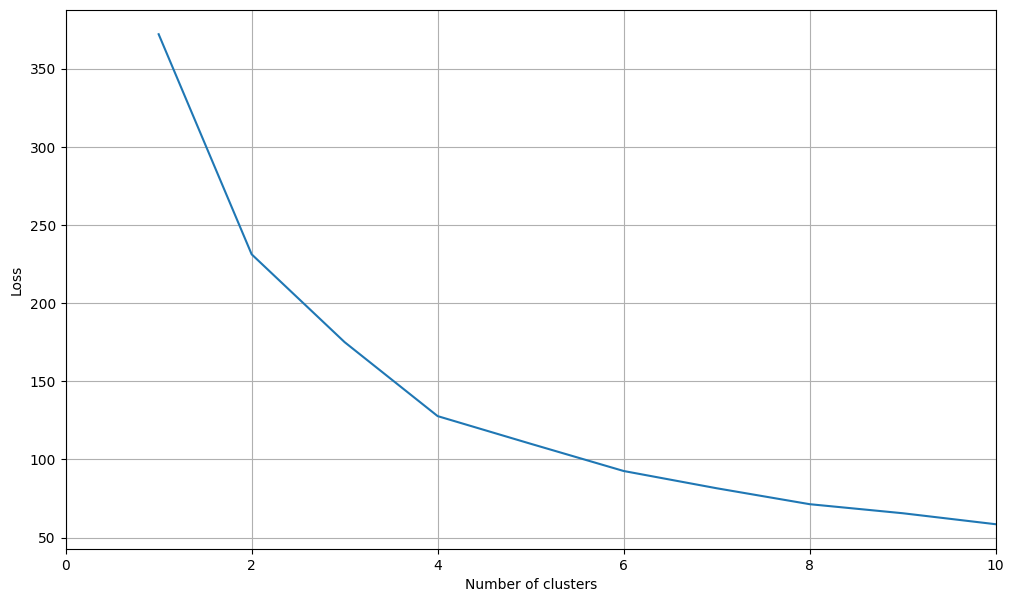

In [110]:
# Scaling data and calculating the loss for 10 clusters
df_phil_start_stations_scaled = scalingData(df_phil_start_stations)
calcAndPlotLoss(10, df_phil_start_stations_scaled)

Looking at the loss function, the amount of clusters should be between 2-4. By testing the cluster amount, 
<br> having 2 clusters is already enough to find similiar groups for both start and end stations.

In [112]:
# Define the cluster amount here
cluster = 2

# Calculating KMeans
calcKMeans(cluster, df_phil_start_stations_scaled)

# Adding the clusters from KMeans into the original dataframe 
df_phil_start_stations_original.loc[:, 'Cluster'] = df_phil_start_stations_scaled['Cluster']

# Sorting cluster values for the map slider
df_phil_start_stations_original.sort_values(by='Cluster', ascending=True, inplace=True)
df_phil_start_stations_original.reset_index(drop=True, inplace=True)

Code for calculating KMeans and plotting is seperated, so that KMeans clusters are not recalculated everytime!

In [113]:
# Scatter Mapbox to display the clusters in a map
fig = px.scatter_mapbox(df_phil_start_stations_original, lat="start_lat", lon="start_lon", animation_frame="Cluster", 
                        opacity=1, animation_group='start_station_name', zoom=12, height=1000, width=900, 
                        hover_name="start_station_name", hover_data=["start_lat", "start_lon"],
                        title='Locational Clusters based on the start stations')
fig.update_geos(center=dict(lon=-75.14, lat=39.96))
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(
    title={
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(
            size=18
        ))
display(fig)

describeData(df_phil_start_stations, df_phil_start_stations_scaled, cluster)

,total_started_trips,avg_trip_duration in minutes,avg_distance_in_km
count,46.000000,46.000000,46.000000
mean,3096.391304,25.803404,2.065695
std,2578.450236,6.745912,0.367143
min,581.000000,17.189680,1.139319
25%,1329.000000,21.116777,1.808131
50%,2339.500000,23.355512,2.079705
75%,4747.500000,29.016456,2.316596
max,14026.000000,45.941848,2.726837


,total_started_trips,avg_trip_duration in minutes,avg_distance_in_km
count,78.000000,78.000000,78.000000
mean,8202.448718,17.432102,1.575329
std,5063.403182,2.824437,0.173340
min,48.000000,12.208333,1.225293
25%,4644.500000,15.262186,1.446492
50%,7726.000000,16.881127,1.541565
75%,10854.750000,19.361124,1.678160
max,24644.000000,26.763823,1.975722


Cluster results from the start stations:
- First cluster <br>
78 stations in the cluster with lowest avg trip duration and lowest avg distance between stations <br>
Stations are generally located around the center of the city. They most likely stay in the center and <br> therefore
do not drive very long and far away.

- Second cluster <br>
46 stations in the cluster with highest avg trip duration and highest avg distance between stations <br>
Stations are generally located further away from the center, so they need to drive longer and further <br> to 
get to their destination. Most likely people that are driving to work or shopping.

#### End Stations

In [114]:
# Aggregation function to combine stations that have multiple stations in itself
agg_functions = {'end_station_name': 'first', 'end_lat': 'mean', 'end_lon': 'mean', 'total_ended_trips': 'sum', 'trip_duration in minutes': 'sum', 'distance_in_km': 'sum'}

# Dataframe for the sum of trip duration and distance per station
descriptiveTripFeatures = df_phil_clustering.groupby(['end_station_name', 'end_lat', 'end_lon']).aggregate({'trip_duration in minutes': 'sum', 'distance_in_km': 'sum'}).reset_index()

# Dataframe for the amount of total trips per station
totalTripCount = df_phil_clustering.groupby(['end_station_name', 'end_lat', 'end_lon'])['end_station_name'].count().reset_index(name='total_ended_trips')

# Merging both dataframes into one
df_phil_end_stations = pd.merge(totalTripCount, descriptiveTripFeatures, on=['end_station_name', 'end_lat', 'end_lon'])

# Show duplicates before aggregating them and one example
display(df_phil_end_stations[df_phil_end_stations.duplicated(subset=['end_station_name'], keep=False)])
display(df_phil_end_stations[df_phil_end_stations['end_station_name'] == '40th Street Station, MFL'])

# Aggregation
df_phil_end_stations = df_phil_end_stations.groupby(df_phil_end_stations['end_station_name']).aggregate(agg_functions).reset_index(drop=True)

# Show duplicates after aggregating to see if they are gone
display(df_phil_end_stations[df_phil_end_stations.duplicated(subset=['end_station_name'], keep=False)])
display(df_phil_end_stations[df_phil_end_stations['end_station_name'] == '40th Street Station, MFL'])

# Copying the original dataframe for visualization and dropping every unnecessary column for KMeans 
df_phil_end_stations_original = df_phil_end_stations.copy()
df_phil_end_stations.drop(['end_station_name', 'end_lat', 'end_lon'], axis=1, inplace=True)

# Calculating avg values for both trip duration and the distance
df_phil_end_stations['avg_trip_duration in minutes'] = df_phil_end_stations['trip_duration in minutes'] / df_phil_end_stations['total_ended_trips']
df_phil_end_stations['avg_distance_in_km'] = df_phil_end_stations['distance_in_km'] / df_phil_end_stations['total_ended_trips']

df_phil_end_stations.drop(['trip_duration in minutes', 'distance_in_km'], axis=1, inplace=True)

# Final dataframe to cluster the end stations
df_phil_end_stations

,end_station_name,end_lat,end_lon,total_ended_trips,trip_duration in minutes,distance_in_km
64,"40th Street Station, MFL",39.956940,-75.200691,1895,40518,3438.095967
65,"40th Street Station, MFL",39.957081,-75.201767,1695,31958,3351.116083
106,"Parkside & Belmont, Case Building",39.977791,-75.213226,308,10398,777.939658
107,"Parkside & Belmont, Case Building",39.978039,-75.212196,1299,42219,3279.611954
112,Philadelphia Museum of Art,39.963711,-75.181602,1545,62814,2391.176417
113,Philadelphia Museum of Art,39.964432,-75.179977,4291,194389,6050.049510
114,Philadelphia Museum of Art,39.964581,-75.180031,8451,362796,12448.271253
115,Philadelphia Zoo,39.974689,-75.195618,82,3554,176.020379
116,Philadelphia Zoo,39.974720,-75.197807,715,22567,1593.360342
127,University City Station,39.948872,-75.189857,6106,94293,11062.630490


,end_station_name,end_lat,end_lon,total_ended_trips,trip_duration in minutes,distance_in_km
64,"40th Street Station, MFL",39.956940,-75.200691,1895,40518,3438.095967
65,"40th Street Station, MFL",39.957081,-75.201767,1695,31958,3351.116083


,end_station_name,end_lat,end_lon,total_ended_trips,trip_duration in minutes,distance_in_km


,end_station_name,end_lat,end_lon,total_ended_trips,trip_duration in minutes,distance_in_km
64,"40th Street Station, MFL",39.957011,-75.201229,3590,72476,6789.212051


,total_ended_trips,avg_trip_duration in minutes,avg_distance_in_km
0,8724,16.571756,1.716513
1,4938,16.980559,1.851371
2,12458,14.557072,1.450137
3,772,20.373057,1.347672
4,8265,17.234604,1.869070
...,...,...,...
119,9498,13.871025,1.865382
120,3815,15.374312,2.051107
121,1475,25.062373,2.898215
122,14664,14.246931,1.684074


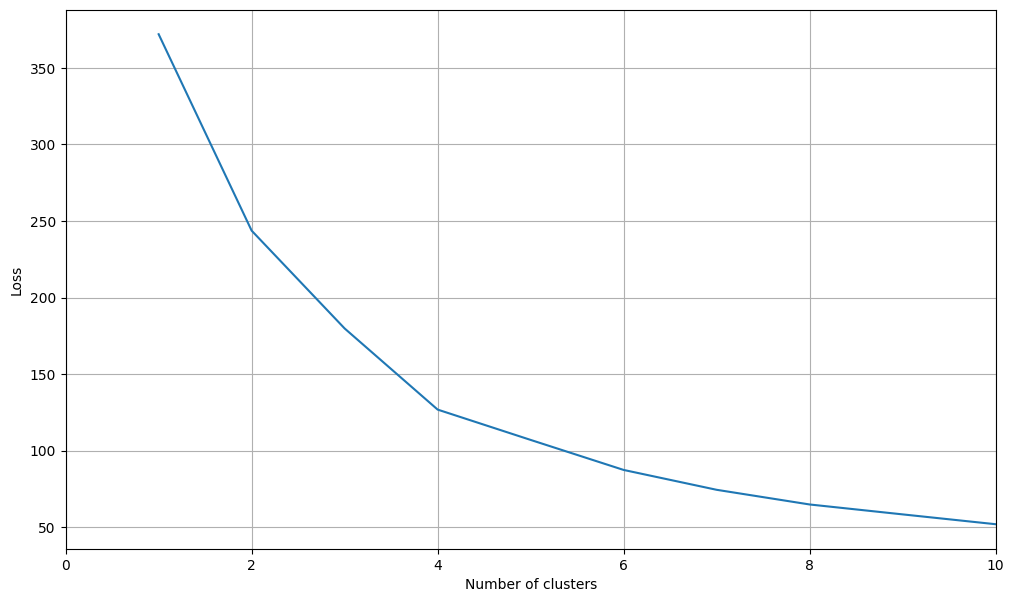

In [115]:
df_phil_end_stations_scaled = scalingData(df_phil_end_stations)
calcAndPlotLoss(10, df_phil_end_stations_scaled)

Looking at the loss function, the amount of clusters should be between 2-4. As found out with testing the amount of clusters, 
<br> having 2 clusters is already enough to find similiar groups for both start and end stations.

In [116]:
# Define the cluster amount here
cluster = 2

# Calculating KMeans
calcKMeans(cluster, df_phil_end_stations_scaled)

# Adding the clusters from KMeans into the original dataframe 
df_phil_end_stations_original.loc[:, 'Cluster'] = df_phil_end_stations_scaled['Cluster']

# Sorting cluster values for the map slider
df_phil_end_stations_original.sort_values(by='Cluster', ascending=True, inplace=True)
df_phil_end_stations_original.reset_index(drop=True, inplace=True)

Code of calculating KMeans and plotting is seperated, so that KMeans clusters are not recalculated everytime!

In [117]:
# Scatter Mapbox to display the clusters in a map
fig = px.scatter_mapbox(df_phil_end_stations_original, lat="end_lat", lon="end_lon", animation_frame="Cluster", 
                        opacity=1, animation_group='end_station_name', zoom=12, height=1000, width=900, 
                        hover_name="end_station_name", hover_data=["end_lat", "end_lon"],
                        title='Locational Clusters based on the end stations')
fig.update_geos(center=dict(lon=-75.14, lat=39.96))
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(
    title={
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(
            size=18
        ))
display(fig)

describeData(df_phil_end_stations, df_phil_end_stations_scaled, cluster)

,total_ended_trips,avg_trip_duration in minutes,avg_distance_in_km
count,54.000000,54.000000,54.000000
mean,3324.111111,25.528973,1.992380
std,2627.295659,7.803419,0.374054
min,548.000000,15.374312,1.126567
25%,1205.000000,20.342920,1.805491
50%,2841.500000,22.790117,2.034693
75%,5001.500000,28.623229,2.246385
max,14287.000000,48.018257,2.898215


,total_ended_trips,avg_trip_duration in minutes,avg_distance_in_km
count,70.000000,70.000000,70.000000
mean,8610.328571,17.249553,1.538393
std,5488.821477,2.401803,0.152175
min,76.000000,12.912581,1.130996
25%,4727.250000,15.572680,1.430005
50%,7821.000000,16.947415,1.523651
75%,11626.000000,18.664216,1.639384
max,25444.000000,24.430393,1.869070


Cluster results from the end stations:
- First cluster <br>
70 stations in the cluster with lowest avg trip duration and lowest avg distance between stations <br>
Stations are generally located around the center of the city. They dont need to drive long and far, <br>because
they live in the center and have everything close to them.

- Second cluster <br>
58 stations in the cluster with highest avg trip duration and highest avg distance between stations <br>
Stations are generally located further away from the center, so they need to drive longer and further <br> to 
get to their destination. Most likely people that are driving home from work or shopping.

Conclusion: <br>
We can find two clusters based on the stations that are further away from the center and the ones that are close to the center of the city.
<br> People from the outside drive into the city for example, for shopping or going to work, and also drive home again from the center to the <br> outside
of the city. People from the inside tend to stay in the center, because there is no necessity for them to leave the center, since <br> everything
they need is available there.